# A simple GAN to generate samples from Gaussian distribution
References:
1. https://github.com/togheppi/vanilla_GAN
2. https://github.com/ericjang/genadv_tutorial/blob/master/genadv1.ipynb
3. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
4. https://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/
5. https://github.com/kremerj/gan
6. https://github.com/igul222/improved_wgan_training
7. https://github.com/AYLIEN/gan-intro/blob/master/gan.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable

## Understand target distribution: Gaussian distribution

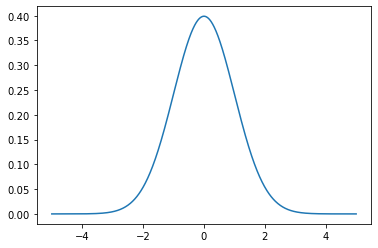

In [2]:
mu,sigma = 0,1
num_samples = 1000
xs = np.linspace(-5, 5, num_samples) # interval = 10/1000=0.01
samples = norm.pdf(xs, mu, sigma)
plt.plot(xs, samples)

## Classes for data sampling

In [3]:
# Real data distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()
        
        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        # Random floats with uniform dist. in the interval [0.0, 0.01)
        offset = np.random.random(num_samples)*0.01
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        
        return samples

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()

        # Fully-connected layer
        fc = nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        nn.init.normal_(fc.weight)
        nn.init.constant_(fc.bias, 0.0)
        # Hidden layer
        self.hidden_layer = nn.Sequential(fc, nn.ReLU())
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.0)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        
        return out

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()

        # Fully-connected layer
        fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        # initializer
        nn.init.normal_(fc1.weight)
        nn.init.constant_(fc1.bias, 0.0)
        # Hidden layer
        self.hidden_layer = nn.Sequential(fc1, nn.ReLU())
        # Fully-connected layer
        fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(fc2.weight)
        nn.init.constant_(fc2.bias, 0.0)
        # Output layer
        self.output_layer = nn.Sequential(fc2, nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        
        return out

## TestSample class

In [6]:
# Test samples
class TestSample:
    def __init__(self, discriminator, generator, realD, data_range, batch_size, num_samples, num_bins):
        self.D = discriminator
        self.G = generator
        self.realD = realD
        self.bs = batch_size
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.xs = np.linspace(-data_range, data_range, num_samples)
        self.bins = np.linspace(-data_range, data_range, num_bins)

    def decision_boundary(self):
        db = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            x_ = self.xs[self.bs*i:self.bs*(i+1)]
            x_ = Variable(torch.FloatTensor(np.reshape(x_, [self.bs, 1])))

            db[self.bs*i:self.bs*(i+1)] = self.D(x_).detach().numpy()

        return db

    def real_distribution(self):
        d = self.realD.sample(self.num_samples)
        p_data, _ = np.histogram(d, self.bins, density=True)
        
        return p_data

    def gen_distribution(self):
        zs = self.xs
        g = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            z_ = zs[self.bs*i:self.bs*(i+1)]
            z_ = Variable(torch.FloatTensor(np.reshape(z_, [self.bs, 1])))
            g[self.bs*i:self.bs*(i+1)] = self.G(z_).detach().numpy()

        p_gen, _ = np.histogram(g, self.bins, density=True)
        
        return p_gen

## Display class 

In [7]:
class Display:
    def __init__(self, num_samples, num_bins, data_range, mu, sigma):
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.data_range = data_range
        self.mu = mu
        self.sigma = sigma
    
    def plot_result(self, db_trained, p_data, p_gen, epoch):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*1.1))
        ax.set_xlim(max(self.mu-self.sigma*5, -self.data_range*0.9), 
                    min(self.mu+self.sigma*5, self.data_range*0.9))
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        save_dir = "result/"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        plt.savefig(save_dir + 'Gaussian' + '_mu_%g' % self.mu +
                    '_sigma_%g' % self.sigma + '_ep_%g' % epoch + '.png')

        plt.show()

    def plot_result_pre(self, db_pre_trained, db_trained, p_data, p_gen):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        ax.plot(d_x, db_pre_trained, '--', label='Decision boundary (pre-trained)')
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*1.1))
        ax.set_xlim(max(self.mu-self.sigma*5, -self.data_range*0.9), 
                    min(self.mu+self.sigma*5, self.data_range*0.9))
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        save_dir = "result/"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        plt.savefig(save_dir + 'Gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()

## Pretrain discriminator

In [8]:
# Hyper-parameters
mu = 0.0
sigma = 1.0
data_range = 5
batch_size = 10

input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 2000
num_epochs_pre = 2000
learning_rate = 0.001

0 3.455188035964966
100 0.9566463232040405
200 0.6071917414665222
300 0.5913034677505493
400 0.516457200050354
500 0.49303948879241943
600 0.4763298034667969
700 0.49895617365837097
800 0.49566972255706787
900 0.49234527349472046
1000 0.4713159501552582
1100 0.44338348507881165
1200 0.4944148659706116
1300 0.49572476744651794
1400 0.4716736972332001
1500 0.5227111577987671
1600 0.46354660391807556
1700 0.46764811873435974
1800 0.4963587820529938
1900 0.4120888411998749


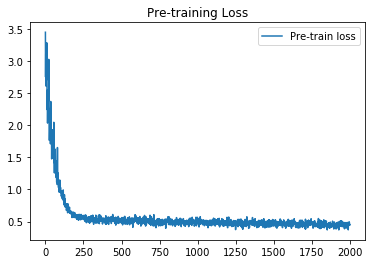

In [9]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim)

# Loss function
bceloss = torch.nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)

num_samples_pre = 1000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    real = realData.sample(num_samples_pre)
    histc, edges = np.histogram(real, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)  # normalize y_ to range [0,1]
    #print('len of y_: ', len(y_), ', y_: ', y_)
    x_ = edges[1:]

    x_ = Variable(torch.FloatTensor(np.reshape(x_, [num_bins_pre, input_dim])))
    y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))

    # Train D model
    optimizer.zero_grad()
    D_pre_decision = D(x_)
    D_pre_loss = bceloss(D_pre_decision, y_)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(epoch, D_pre_loss.item())
    #print(epoch, D_pre_loss.item())

# Plot loss
fig, ax = plt.subplots()
losses = np.array(D_pre_losses)
plt.plot(losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

In [ ]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Test sample after pre-training (to be drawn later)
num_samples = 10000
num_bins = 50
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_pre_trained = sample.decision_boundary()

## Save and reload (if necessary during training)

In [10]:
# Save generator, discriminator
torch.save(G.state_dict(), './SavedModel/G_pretrain.pt')
torch.save(D.state_dict(), './SavedModel/D_pretrain.pt')

In [12]:
# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim)

# Load models
G.load_state_dict(torch.load('./SavedModel/G_pretrain.pt'))
D.load_state_dict(torch.load('./SavedModel/D_pretrain.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
print("G's state_dict:")
for param_tensor in G.state_dict():
    print(param_tensor, "\t", G.state_dict()[param_tensor].size())

G's state_dict:
hidden_layer.0.weight 	 torch.Size([32, 1])
hidden_layer.0.bias 	 torch.Size([32])
output_layer.weight 	 torch.Size([1, 32])
output_layer.bias 	 torch.Size([1])


In [12]:
print("D's state_dict:")
for param_tensor in D.state_dict():
    print(param_tensor, "\t", D.state_dict()[param_tensor].size())

D's state_dict:
hidden_layer.0.weight 	 torch.Size([32, 1])
hidden_layer.0.bias 	 torch.Size([32])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])


## Train GAN

epoch:0, D loss:0.9159927368164062, G loss:15.24650764465332


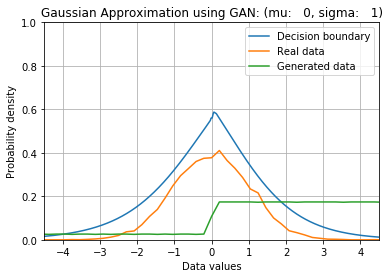

epoch:100, D loss:1.1739715337753296, G loss:4.8734941482543945


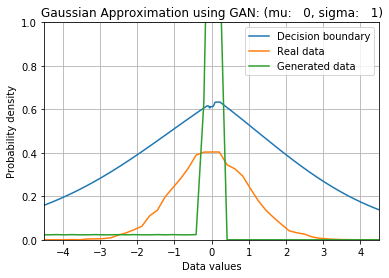

epoch:200, D loss:1.0692691802978516, G loss:2.709475040435791


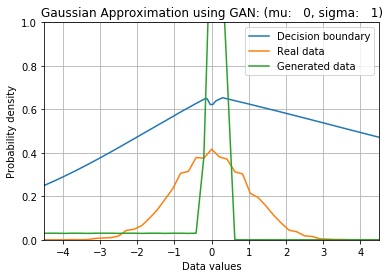

epoch:300, D loss:1.1273910999298096, G loss:1.7011668682098389


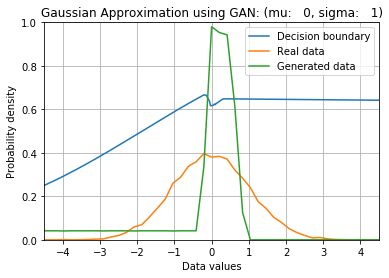

epoch:400, D loss:1.24778413772583, G loss:0.8612532615661621


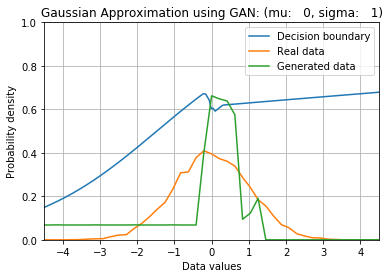

epoch:500, D loss:1.4219609498977661, G loss:0.5663363337516785


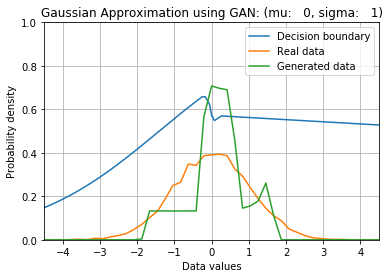

epoch:600, D loss:1.4466845989227295, G loss:0.5805156826972961


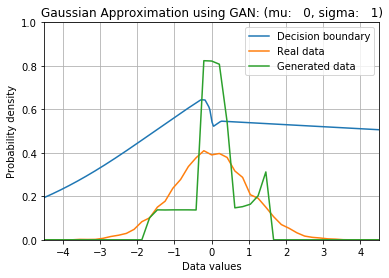

epoch:700, D loss:1.377007246017456, G loss:0.5942236185073853


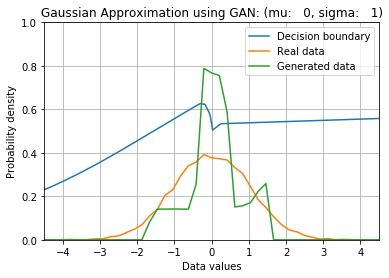

epoch:800, D loss:1.4067528247833252, G loss:0.6067463755607605


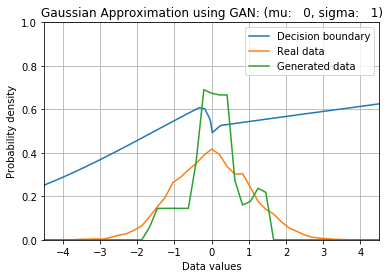

epoch:900, D loss:1.38634192943573, G loss:0.6194659471511841


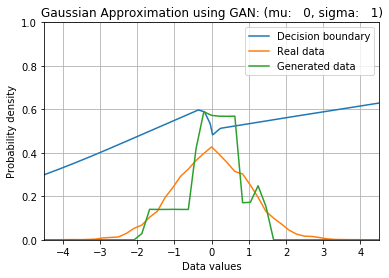

epoch:1000, D loss:1.4105991125106812, G loss:0.6314350366592407


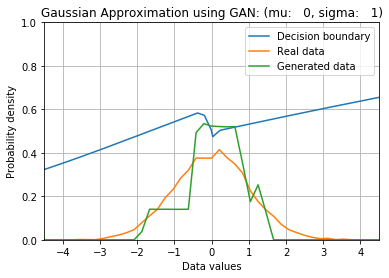

epoch:1100, D loss:1.3673436641693115, G loss:0.6435145735740662


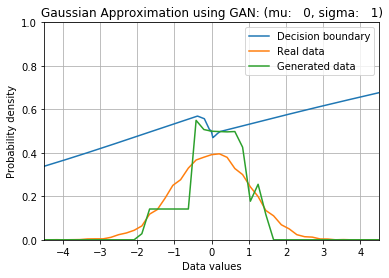

epoch:1200, D loss:1.3689173460006714, G loss:0.6573988795280457


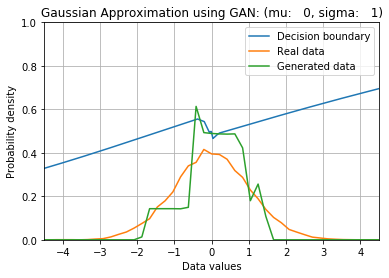

epoch:1300, D loss:1.4024462699890137, G loss:0.6697376370429993


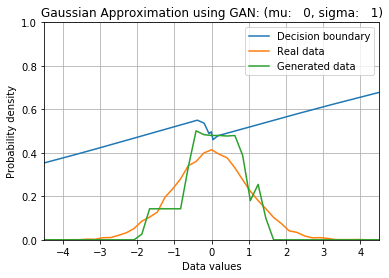

epoch:1400, D loss:1.3781688213348389, G loss:0.671521782875061


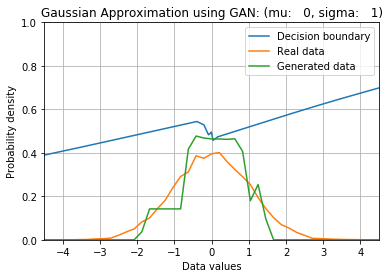

epoch:1500, D loss:1.3854210376739502, G loss:0.6843433380126953


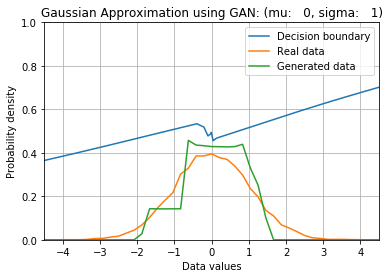

epoch:1600, D loss:1.383885383605957, G loss:0.6898726224899292


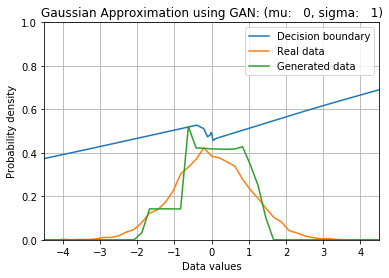

epoch:1700, D loss:1.3726918697357178, G loss:0.6953734159469604


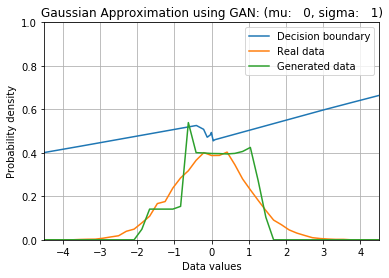

epoch:1800, D loss:1.4097909927368164, G loss:0.6988570690155029


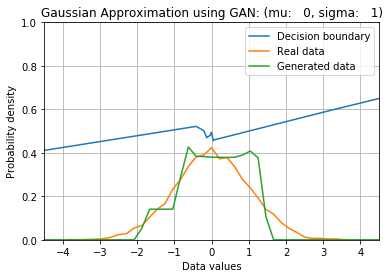

epoch:1900, D loss:1.3890622854232788, G loss:0.7027865648269653


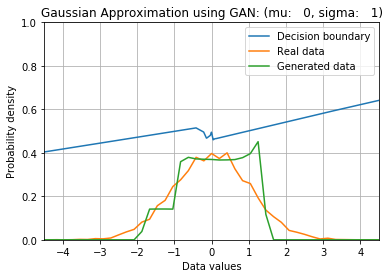

In [12]:
# Optimizers
D_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)

# Loss function
bceloss = torch.nn.BCELoss()

D_losses = []
G_losses = []
num_epochs = 2000
for epoch in range(num_epochs):
    # Generate samples
    x_ = realData.sample(batch_size)
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size, input_dim])))
    y_real_ = Variable(torch.ones([batch_size, output_dim]))
    y_fake_ = Variable(torch.zeros([batch_size, output_dim]))

    # Train discriminator with real data
    D_real_decision = D(x_)
    D_real_loss = bceloss(D_real_decision, y_real_)

    # Train discriminator with fake data
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    D_fake_loss = bceloss(D_fake_decision, y_fake_)

    D_loss = D_real_loss + D_fake_loss
    
    # Back propagation
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    G_loss = bceloss(D_fake_decision, y_real_) # note that we put y_real_ here

    # Back propagation
    D.zero_grad()
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # Save loss values for plot
    D_losses.append(D_loss.item())
    G_losses.append(G_loss.item())

    if epoch % 100 == 0:
        print('epoch:{}, D loss:{}, G loss:{}'.format(epoch, D_loss.item(), G_loss.item()))
        # Test sample after GAN-training
        sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
        db_trained = sample.decision_boundary()
        p_data = sample.real_distribution()
        p_gen = sample.gen_distribution()

        # Display result
        display = Display(num_samples, num_bins, data_range, mu, sigma)
        display.plot_result(db_trained, p_data, p_gen, epoch)

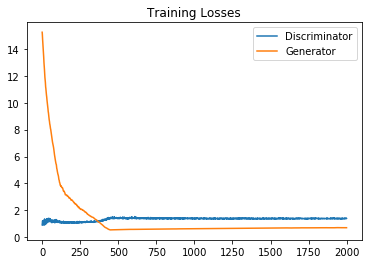

In [13]:
# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

## Note: After GAN training, decision boundary ~ 0.5, indicating the generated data confuse disc.

# (Optional) Create gif for visualizing the training evolution

In [13]:
import imageio

png_dir = './result/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

In [16]:
imageio.mimsave('./result/gif/training.gif', images, fps=5)